# DPAP Clustering - RMSD

using 10k frames from the DPAP-ACN trajectory

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import scipy as sp
import sys
from sklearn import datasets, metrics, cluster

from IPython import display
%matplotlib inline

In [2]:
sys.path.append("../src")
import mdutils
import myclusters2
import mymetrics2
import pyusr

## Load data and set envs

In [4]:
data_dir = "/home/g.mancini/scratch/DPAP_trajs/dpap_acn/"
os.chdir(data_dir)
!ls

#nshell.xvg.1#	     energy.agr.gz    rdf.xvg
#order.xtc.1#	     energy.xvg       rmsd.dat.bz2
200frames	     fixed.edr	      rmsd.xvg
autocorr.xvg	     fshell.pdb       rmsd_dpap_acn_50ps.dat
center_50ps.xtc      fshell.xtc       rmsd_hex.dat.bz2
confout.gro	     index.ndx	      testD1.tpr
dpap.pdb	     nojump_50ps.xtc  tmp
dpap_fit_50ps.xtc    nshell.dat       traj.xtc
dpap_nofit_50ps.xtc  nshell.xvg       usrmat_50ps_dpap.dat
ener.part0002.edr    order.xtc	      usrmat_50ps_dpap.dat.tar.bz2
ener_part1.edr	     rdf.dat


In [6]:
data = np.loadtxt("rmsd.dat.bz2")

## Test1: PAM

In [7]:
K = [k for k in range(2,30)]
nfeatures = 36
niter = 5000
restart = 15
conv = 1e-6
centroid = list()

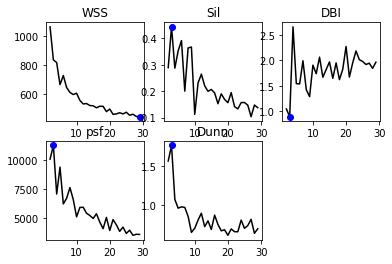

In [8]:
sil = list()
DBI = list()
psf = list()
Dunn= list()
WSS = list()

for k in K:
    my_estimator = myclusters2.PAM(D=data,X=None,K=k,\
                                   niter=niter,nrun=restart,boot='random',conv=conv,metric='precomputed')
    my_estimator.do_clustering()
    myclusters = my_estimator.clusters
    centroid.append(set(myclusters))
    WSS.append(my_estimator.inertia)
    
    myeval = mymetrics2.cluster_eval(metric='precomputed',clusters=myclusters,D=data)
    DBI.append(myeval(noise="ignore",method="DBI"))
    Dunn.append(myeval(noise="ignore",method="Dunn",inter="allav",intra="allav"))
    psf.append(myeval(noise="ignore",method="psF",centroid=True)[0])
    sil.append(metrics.silhouette_score(data,myclusters,metric='precomputed'))   

plt.figure()    

plt.subplot(231)
WSS = np.asarray(WSS); vmax = np.min(WSS); kmax = np.argmin(WSS)+2
plt.plot(K,WSS,'k',kmax, vmax, 'bo')
plt.title('WSS')

plt.subplot(232)
sil = np.asarray(sil); vmax = np.max(sil); kmax = np.argmax(sil)+2
plt.plot(K,sil,'k',kmax, vmax, 'bo')
plt.title('Sil')

plt.subplot(233)
DBI = np.asarray(DBI); vmax = np.min(DBI); kmax = np.argmin(DBI)+2
plt.plot(K,DBI,'k',kmax, vmax, 'bo')
plt.title('DBI')

plt.subplot(234)
psf = np.asarray(psf); vmax = np.max(psf); kmax = np.argmax(psf)+2
plt.plot(K,psf,'k',kmax, vmax, 'bo')
plt.title('psf')

plt.subplot(235)
Dunn = np.asarray(Dunn); vmax = np.max(Dunn); kmax = np.argmax(Dunn)+2
plt.plot(K,Dunn,'k',kmax, vmax, 'bo')
plt.title('Dunn')

plt.show()

In [9]:
print("centroids",set(centroid[2]))

centroids {8306, 4371, 8884, 6573}


## Density Peaks

In [10]:
spacedef="precomputed"
usenoise="ignore"
percent = np.array((0.5,1.,1.5,2.,2.5,3.))
#percent = np.array((1.,1.5,1.75))
ndata = data.shape[0]


############################

Determining cutoff using a % of neighbors= 0.5
Cutoff 0.029425


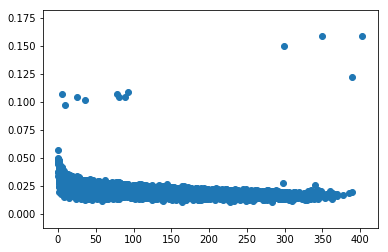


############################

Determining cutoff using a % of neighbors= 1.0
Cutoff 0.032933


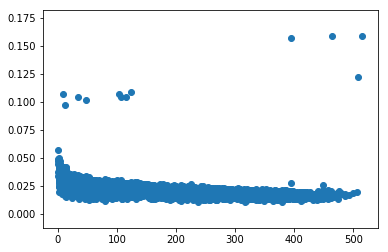


############################

Determining cutoff using a % of neighbors= 1.5
Cutoff 0.035444


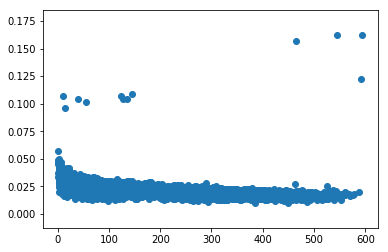


############################

Determining cutoff using a % of neighbors= 2.0
Cutoff 0.03753


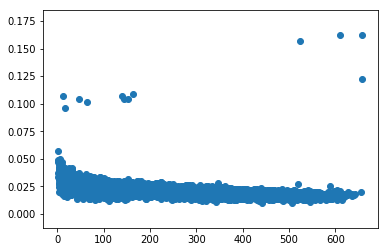


############################

Determining cutoff using a % of neighbors= 2.5
Cutoff 0.039367


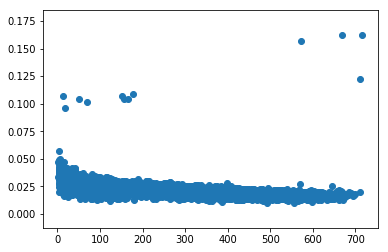


############################

Determining cutoff using a % of neighbors= 3.0
Cutoff 0.041044


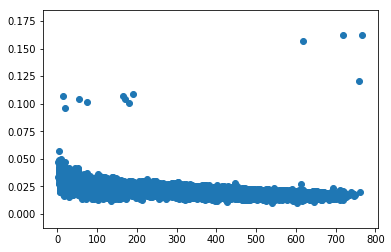

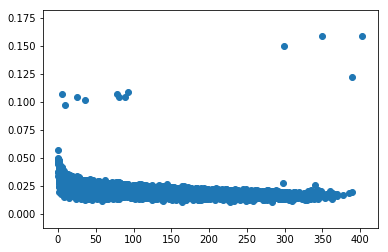

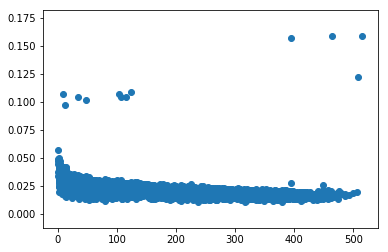

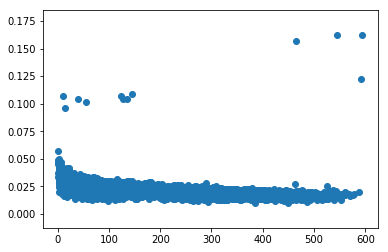

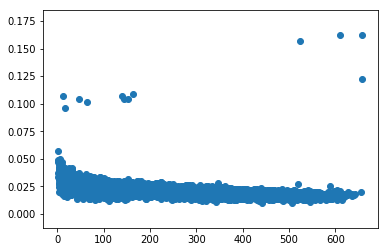

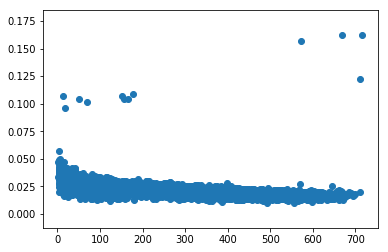

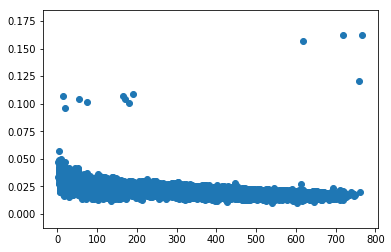

In [11]:
for p in percent:
    fig = plt.figure()
    print("\n############################\n")
    ###############
    estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                     kernel="gaussian",D=data)
    print("Cutoff",estimator.cutoff)
    rho,delta = estimator.decision_graph()
    plt.scatter(rho,delta)
    display.display(fig)

In [13]:
RMIN = 300
DELTA = 0.1
p = 3.0

In [14]:
estimator = myclusters2.density_peaks(cutoff="auto",percent=p,metric="precomputed",\
                                 kernel="gaussian",D=data)
print("Cutoff",estimator.cutoff)
rho,delta = estimator.decision_graph()
centroids,points = estimator.get_centroids(rmin=RMIN,dmin=DELTA)
clusters = estimator.assign_points()

robust_clusters = estimator.create_halo()
halo = 0
for c in centroids:
    N = len(robust_clusters[robust_clusters==c])
    H = len(clusters[clusters==c]) - N
    halo = halo + H
    print("%d elements and %d HALO points found in cluster %d" % (N,H,c))        
norm = (ndata-halo)/ndata

Determining cutoff using a % of neighbors= 3.0
Cutoff 0.041044
1691 elements and 816 HALO points found in cluster 5015
1003 elements and 1435 HALO points found in cluster 6344
869 elements and 1466 HALO points found in cluster 7557
2016 elements and 705 HALO points found in cluster 9133


## Affinity Propagation

In [21]:
pref=None
max_it=300
conv=20
dam=0.75

In [22]:
af = cluster.AffinityPropagation(preference=pref,max_iter=max_it,convergence_iter=conv,\
                                 affinity="precomputed",damping=dam)
af.fit(data)
cluster_centers_indices = af.cluster_centers_indices_
labels = af.labels_

In [23]:
cluster_centers_indices,len(cluster_centers_indices)

(array([  45,  175,  484,  818,  852, 1074, 1121, 1454, 1541, 1546, 1547,
        1657, 1789, 1846, 1898, 9527, 9531, 9602, 9624, 9633, 9705, 9761,
        9776, 9801, 9808, 9814, 9857, 9866, 9874, 9895, 9901, 9964]), 32)